<a href="https://colab.research.google.com/github/serinss/seSAC_ML_DL_Class/blob/main/05_1_%EA%B2%B0%EC%A0%95_%ED%8A%B8%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#로지스틱 회귀로 와인 분류하기

https://archive.ics.uci.edu/ml/index.php  
해당 사이트에 데이터 세트 많음 -> 여기서 문제 많이 풀어볼 수 있음 (석사 1년차 훈련할 때에 자주 쓰임)

In [1]:
%run my_init.py

Mounted at /content/drive


In [2]:
%matplotlib inline

In [3]:
wine = pd.read_csv('https://bit.ly/wine_csv_data')
wine.head()

# https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009 출처

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [4]:
wine.info() #결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [5]:
np.unique(wine['class']) # 음성(0) : 레드와인, 양성(1) : 화이트 와인 -> 거꾸로 보지 않도록 주의!

array([0., 1.])

In [6]:
wine.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [7]:
wine.iloc[:, :-1].describe() # 매우 중요하므로 필기 확인하기!!

,alcohol,sugar,pH
count,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501
std,1.192712,4.757804,0.160787
min,8.000000,0.600000,2.720000
25%,9.500000,1.800000,3.110000
50%,10.300000,3.000000,3.210000
75%,11.300000,8.100000,3.320000
max,14.900000,65.800000,4.010000


In [8]:
wine.iloc[1:3:1, 0:3:1] 
# 행 : 두번째 부터 4번째 행까지 1씩
# 열 : 첫번째 열부터 3번째 열까지 1씩

,alcohol,sugar,pH
1,9.8,2.6,3.20
2,9.8,2.3,3.26


In [9]:
# wine.loc[1:4, :3]
# # annot do slice indexing on Index with these indexers [3] of type int
# 이름이 있으면 명시적 인덱스를 슬라이싱 하는 함수를 사용해야함 -> iloc필요!

In [10]:
wine.iloc[1:4, :-1] # start:stop:step (Implicit이면 stop 인덱스 불포함)

,alcohol,sugar,pH
1,9.8,2.6,3.20
2,9.8,2.3,3.26
3,9.8,1.9,3.16


In [11]:
wine.loc[1:3, 'alcohol':'pH'] # Explicit 이면 stop 인덱스 포함

,alcohol,sugar,pH
1,9.8,2.6,3.20
2,9.8,2.3,3.26
3,9.8,1.9,3.16


In [12]:
wine.iloc[1:4, :3]

,alcohol,sugar,pH
1,9.8,2.6,3.20
2,9.8,2.3,3.26
3,9.8,1.9,3.16


In [13]:
pd.Categorical(wine['class']).describe() # 빈도, 비율
# 4분위수는 연속형에서 중요
# 범주형에서 중요한 것은 빈도 정보임

,counts,freqs
categories,,
0.0,1599,0.246114
1.0,4898,0.753886


In [14]:
wine.loc[:, 'alcohol':'pH'].describe() #연속형은 연속형끼리 범주형은 범주형끼리

,alcohol,sugar,pH
count,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501
std,1.192712,4.757804,0.160787
min,8.000000,0.600000,2.720000
25%,9.500000,1.800000,3.110000
50%,10.300000,3.000000,3.210000
75%,11.300000,8.100000,3.320000
max,14.900000,65.800000,4.010000


In [15]:
wine['class'].astype('category').describe() # 타입 변경 가능

count     6497.0
unique       2.0
top          1.0
freq      4898.0
Name: class, dtype: float64

In [16]:
pd.Categorical(wine['class']).describe()

,counts,freqs
categories,,
0.0,1599,0.246114
1.0,4898,0.753886


In [17]:
pd.Categorical(wine['class'].astype('int')).describe()

,counts,freqs
categories,,
0,1599,0.246114
1,4898,0.753886


#결정 트리(Decision Tree, Gini Impurity Index : 지니 불순도 지수)
- 장점 : 루트 노드(Root Node)의 중요한 정보가 들어가 있음
- 단점 : 과적합 모델, 성능이 떨어지는 코어

###결정 트리 -> 여러개의 코어로 모아둔 것이 포레스트!
이것이 꽤 성능이 좋음  

현업에서 실제로 사용하는 알고리즘은 다른것이 많음  
부스트, 등등 

In [18]:
data = wine.iloc[:, :-1].to_numpy()
target = wine['class'].to_numpy()
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)

In [19]:
train_input.shape, train_target.shape

((5197, 3), (5197,))

In [20]:
test_input.shape, test_target.shape

((1300, 3), (1300,))

In [21]:
# 트리 계열은 전처리 필요 없음
# 스케일링은 항상 원본 데이터가 변경되므로 트리에서는 값을 알아보기 힘듦

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_input, train_target)

DecisionTreeClassifier(random_state=42)

In [22]:
print(accuracy_score(train_target, dt.predict(train_input)))
print(accuracy_score(test_target, dt.predict(test_input)))

#과적합 상태

0.996921300750433
0.8584615384615385


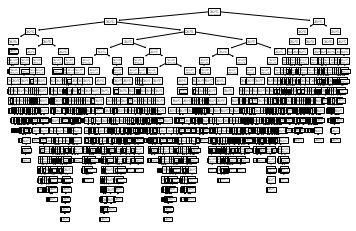

In [23]:
from sklearn.tree import plot_tree

plot_tree(dt)
plt.show()

In [36]:
fnames = wine.iloc[:, :-1].columns.to_numpy() #컬럼의 종류를 미리 확인하여 이름을 붙여줄 수 있음
fnames

# feature정보로 썼던 컬럼들만 필요함을 주의

array(['alcohol', 'sugar', 'pH'], dtype=object)

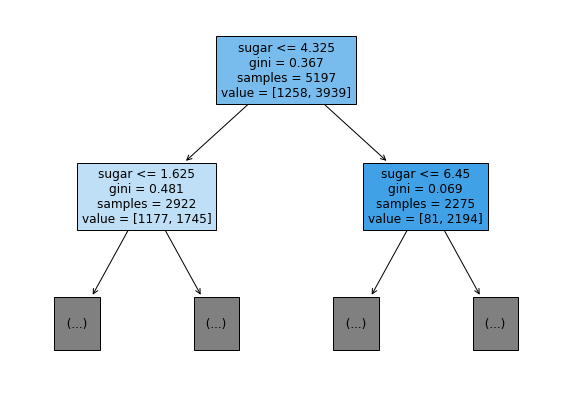

In [37]:
plt.figure(figsize=(10,7))
plot_tree(dt, max_depth=1, filled=True, feature_names=fnames)
plt.show()

# filled=True 색깔 입히기 -> 어떤 클래스의 비율이 높아지면 점점 진해진다!
# feature_names=['alcohol','sugar','pH'] 기존의 X[1] = sugar로 표기 - 책처럼 절대 쓰지 말기

# 왼쪽 : 당도가 4.325보다 작은것
# 오른쪽 : 큰 것

In [40]:
data.shape, train_input.shape, test_input.shape
# 샘플 총 5197건 = 1258건 + 3939건

((6497, 3), (5197, 3), (1300, 3))

In [45]:
np.unique(train_target, return_counts=True) #시작 지점의 루트노트 값 확인

(array([0., 1.]), array([1258, 3939]))

#가지치기(Pruning)
왜 하는가?  
plot.tree()는 학습이 아니라 전체적인 그림을 본 것  
훈련을 할 때에, 우리는 max_depth라는 hyper parameter를 설정하여 학습

In [51]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42) 
dt.fit(train_input, train_target)
print(accuracy_score(train_target, dt.predict(train_input)))
print(accuracy_score(test_target, dt.predict(test_input)))

# splitter : {"best", "random"}, default="best" 정보이득을 최대화하는 전략
# min_samples_split=2 샘플이 분리되기 위해서는 노드가 적어도 2개는 있어야 한다 (최소 조건)

0.8454877814123533
0.8415384615384616


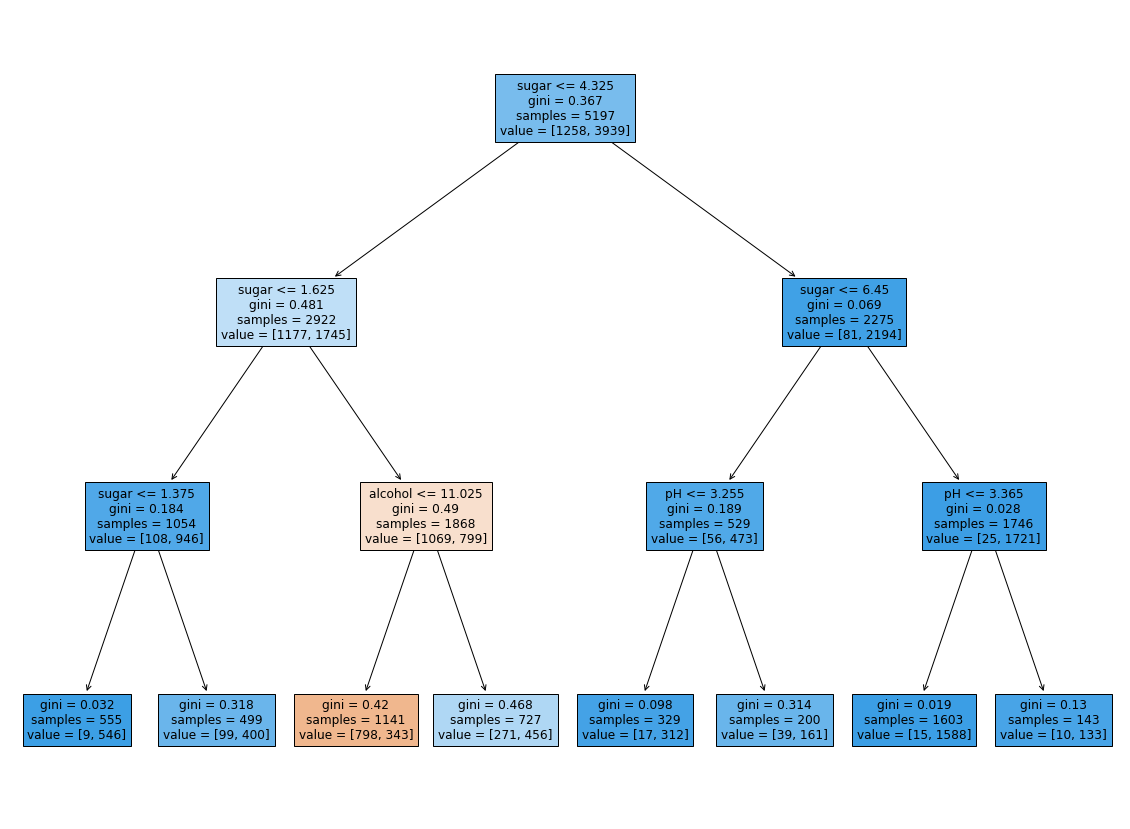

In [53]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=fnames)
plt.show()

In [54]:
print(dt.feature_importances_)
# 어떤 특성이 가장 유용한지 나타내는 특성 중요도 계산
# 당도가 0.87으로 제일 높음

[0.12345626 0.86862934 0.0079144 ]


In [66]:
# 현업에서 중요한 feature 탑 3를 구하고 싶으면? -> sort필요

np.argsort(dt.feature_importances_) #중요도가 낮은 순서대로(오름차순) 인덱스 값 반환

array([2, 0, 1])

In [77]:
desc_idx = np.argsort(dt.feature_importances_)[::-1] #내림차순
desc_idx

array([1, 0, 2])

In [93]:
fnames = wine.loc[:, :'pH']
fnames

,alcohol,sugar,pH
0,9.4,1.9,3.51
1,9.8,2.6,3.20
2,9.8,2.3,3.26
3,9.8,1.9,3.16
4,9.4,1.9,3.51
...,...,...,...
6492,11.2,1.6,3.27
6493,9.6,8.0,3.15
6494,9.4,1.2,2.99
6495,12.8,1.1,3.34


In [90]:
top3 = fnames[desc_idx][:3]
top3

KeyError: ignored

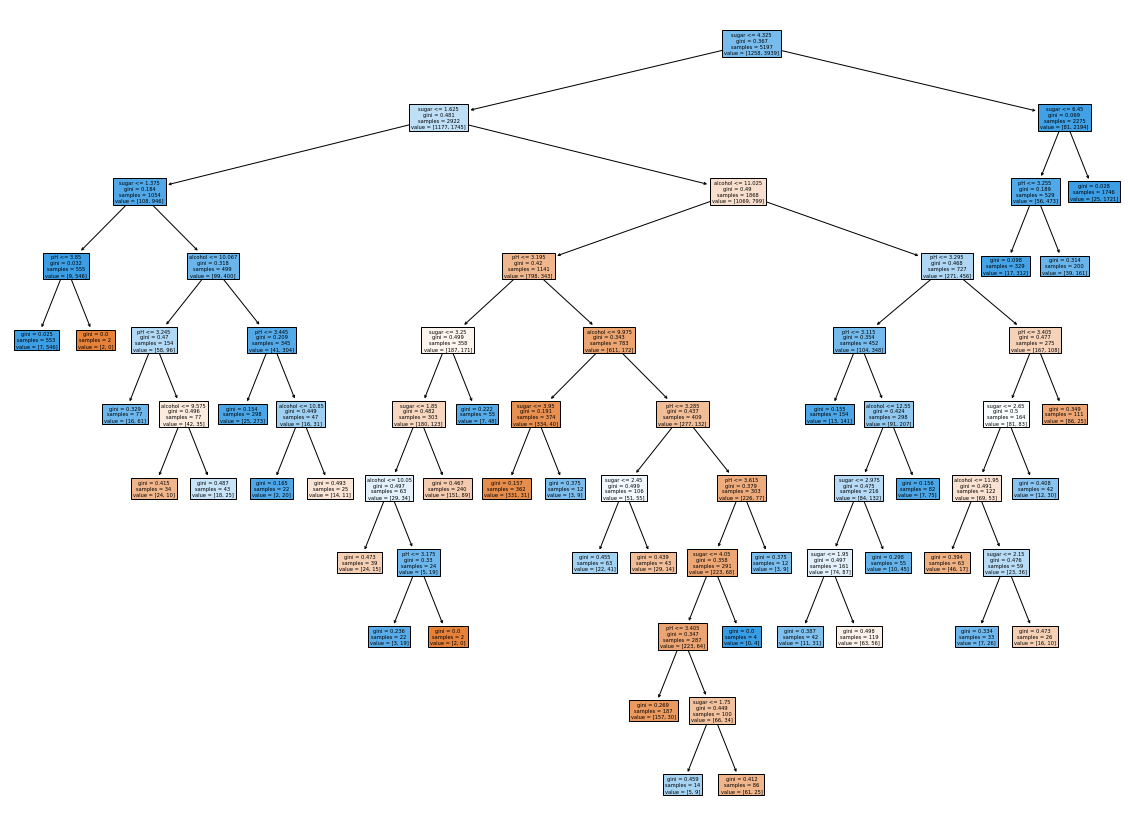

In [61]:
# 연습문제 3

dt = DecisionTreeClassifier(min_impurity_decrease=0.0005, random_state=42)
dt.fit(train_input, train_target)

plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=fnames)
plt.show()